In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [2]:
import os
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
# Load dataset
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [4]:
data = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')



In [6]:
data.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [7]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
# Count number of missing value
num_missing = data.isnull().sum().sum()
print("Number of rows with missing values:", num_missing)

Number of rows with missing values: 0


In [9]:
# Count number of duplicate values
duplicate_rows = data.duplicated()
num_duplicates = duplicate_rows.sum()
print("Number of rows with duplicate values:", num_duplicates)

Number of rows with duplicate values: 0


In [10]:
def visualize_distribution(dataframe, column):
    plt.figure(figsize=(4, 3))

    # Distribution visualization
    if data[column].dtype == 'category':
        counts = data[column].value_counts().sort_index()
        labels = counts.index.astype(str)
        sizes = counts.values
        colors = sns.color_palette('Oranges', len(labels))
        patches, texts, autotexts = plt.pie(sizes, colors=colors, startangle=90,
                                            wedgeprops={'linewidth': 0.35, 'edgecolor': 'black'},
                                            autopct='%1.1f%%')

        # Customizing labels
        plt.gca().set_aspect('equal')
        plt.title(f'Distribution of {column}', fontsize=10)
        plt.legend(patches, labels, loc='upper right', bbox_to_anchor=(1.15, 1), frameon=True,
                   labelspacing=0.5, fontsize=6, title=None,
                   handletextpad=1, handlelength=0.8)

        # Add percentages to legend
        total = sum(sizes)
        percentages = [f'{(100 * size / total):.1f}%' for size in sizes]
        for i, text in enumerate(plt.gca().get_legend().get_texts()):
            text.set_text(f'{labels[i]} ({percentages[i]})')

        # Add percentages inside the pie chart (only for >= 10%)
        for autotext, size in zip(autotexts, sizes):
            if size / sum(sizes) >= 0.1:
                autotext.set_color('black')
                autotext.set_fontsize(8)
            else:
                autotext.set_text('')

    else:
        plt.grid(True, linestyle='dotted', linewidth=0.5, alpha=1, zorder=0)
        sns.histplot(data[column], bins=25, color='orange', edgecolor='black')

        # Add dashed lines for outlier boundaries
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        if lower_bound >= 0:
            plt.axvline(lower_bound, color='purple', linestyle='dashed', linewidth=0.75, label='Lower Bound')
        plt.axvline(upper_bound, color='blue', linestyle='dashed', linewidth=0.75, label='Upper Bound')

        plt.xlabel(column.capitalize(), fontsize=8)
        plt.ylabel('Count', fontsize=8)
        plt.title(f'Distribution of {column}', fontsize=10)
        plt.legend(fontsize=6)

    plt.tight_layout()
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


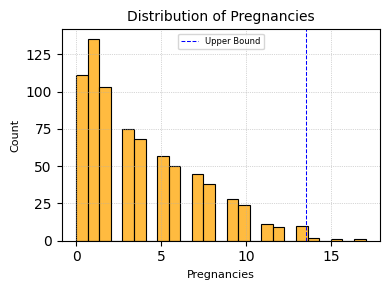

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


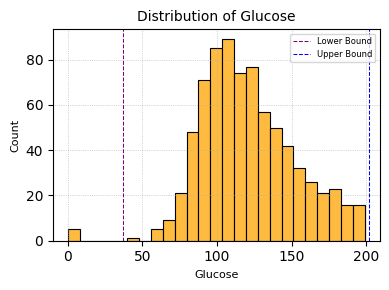

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


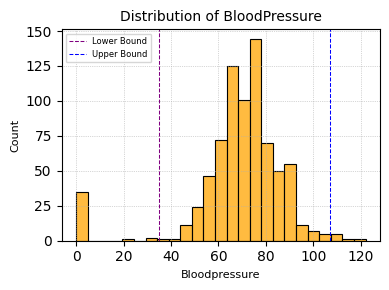

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


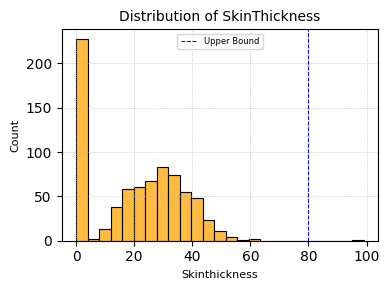

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


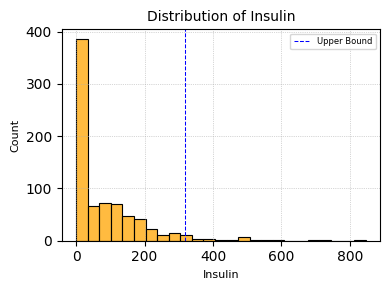

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


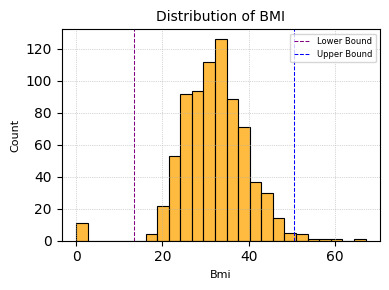

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


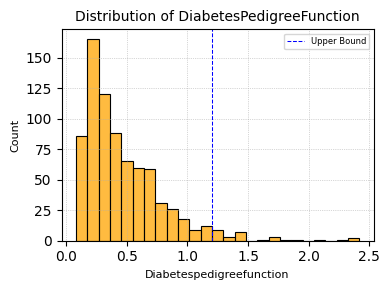

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


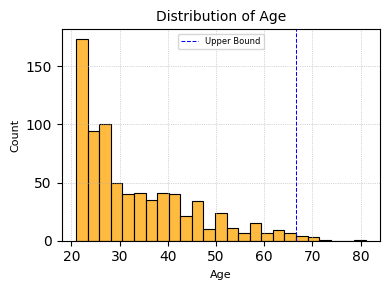

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


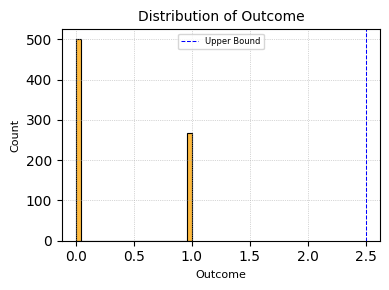

In [11]:
# Get the column names of the DataFrame
columns = data.columns

# Iterate over each column and visualize the distribution
for column in columns:
    visualize_distribution(data, column)
    print()

In [18]:
def binary_bat_algorithm(population_size, loudness, pulse_rate, max_iterations, dataframe):
    """
    Binary Bat Algorithm (BBA) implementation.

    Parameters:
    - population_size: Number of individuals in the population
    - loudness: Loudness of the bats
    - pulse_rate: Pulse rate of the bats
    - max_iterations: Maximum number of iterations
    - dataframe: DataFrame containing the features and target

    Returns:
    - best_solution: Best solution found
    - best_fitness: Best fitness value
    - convergence_curve: Array of best fitness values at each iteration
    - accuracy_curve: Array of best accuracy values at each iteration
    - con_matrix : Confusion matrix of the best solution
    - classification_report: Classification report of the best solution
    """
    # Frequency range
    min_frequency = 0  # Minimum frequency
    max_frequency = 2  # Maximum frequency

    # Extract features and target from the dataframe
    features = dataframe.drop(columns=['Outcome'])
    target = dataframe['Outcome']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Initialize arrays
    dimension = len(features.columns)
    frequency = np.zeros(population_size)  # Frequency
    velocity = np.zeros((population_size, dimension))  # Velocities
    solutions = np.zeros((population_size, dimension), dtype=int)
    convergence_curve = np.zeros(max_iterations)
    accuracy_curve = np.zeros(max_iterations)

    # Initialize the population/solutions
    for i in range(population_size):
        solutions[i] = np.random.randint(0, 2, dimension)

    fitness = np.zeros(population_size)
    for i in range(population_size):
        selected_features = features.columns[solutions[i].astype(bool)]
        clf = RandomForestClassifier(n_estimators=20, random_state=12, max_depth=3)
        clf.fit(X_train[selected_features], y_train)
        y_pred = clf.predict(X_test[selected_features])
        fitness[i] = accuracy_score(y_test, y_pred)

    # Find the current best
    best_fitness = np.max(fitness)  # Find the best fitness value (maximum)
    best_index = np.argmax(fitness)  # Find the index of the best fitness value
    best_solution = solutions[best_index].copy()  # Copy the best solution

    # Start the iterations - Binary Bat Algorithm
    current_iteration = 0
    while current_iteration < max_iterations:
        current_iteration += 1
        convergence_curve[current_iteration - 1] = best_fitness
        accuracy_curve[current_iteration - 1] = best_fitness
        for i in range(population_size):
            for j in range(dimension):
                frequency[i] = min_frequency + (min_frequency - max_frequency) * np.random.rand()
                velocity[i, j] = velocity[i, j] + (solutions[i, j] - best_solution[j]) * np.random.rand()
                v_shaped_transfer_function = np.abs((2 / np.pi) * np.arctan((np.pi / 2) * velocity[i, j]))
                if np.random.rand() < v_shaped_transfer_function:
                    solutions[i, j] = 1 - solutions[i, j]
                else:
                    solutions[i, j] = solutions[i, j]
                if np.random.rand() > pulse_rate:
                    solutions[i, j] = best_solution[j]
            selected_features = features.columns[solutions[i].astype(bool)]
            clf = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=3)
            clf.fit(X_train[selected_features], y_train)
            y_pred = clf.predict(X_test[selected_features])
            new_fitness = accuracy_score(y_test, y_pred)

            if new_fitness >= fitness[i] and np.random.rand() < loudness:
                solutions[i] = solutions[i]
                fitness[i] = new_fitness

            if new_fitness >= best_fitness:
                best_solution = solutions[i].copy()
                best_fitness = new_fitness

        # Display Output
        print("Iteration:", current_iteration)
        print("Selected Features:", features.columns[best_solution.astype(bool)].tolist())
        print("Best Accuracy:", best_fitness, "\n")

        if current_iteration == max_iterations:
            # Calculate and display confusion matrix
            selected_features = features.columns[best_solution.astype(bool)]
            clf = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=3)
            clf.fit(X_train[selected_features], y_train)
            y_pred = clf.predict(X_test[selected_features])
            con_matrix = confusion_matrix(y_test, y_pred)

            # Calculate and display classification report
            report = classification_report(y_test, y_pred)

    return best_solution, best_fitness, convergence_curve, accuracy_curve, con_matrix, report

In [19]:
# Set parameter for binary bat algorithm
population_size = 100  # Number of individuals in the population
loudness = 0.5         # Loudness of the bats
pulse_rate = 0.5       # Pulse rate of the bats
max_iterations = 25    # Maximum iterations

In [20]:
# Call binary_bat_algorithm function
best_solution, best_fitness, convergence_curve, accuracy_curve, con_matrix, report = binary_bat_algorithm(population_size, loudness, pulse_rate, max_iterations, data)

Iteration: 1
Selected Features: ['Pregnancies', 'Glucose', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction']
Best Accuracy: 0.8116883116883117 

Iteration: 2
Selected Features: ['Pregnancies', 'Glucose', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction']
Best Accuracy: 0.8116883116883117 

Iteration: 3
Selected Features: ['Pregnancies', 'Glucose', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction']
Best Accuracy: 0.8116883116883117 

Iteration: 4
Selected Features: ['Pregnancies', 'Glucose', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction']
Best Accuracy: 0.8116883116883117 

Iteration: 5
Selected Features: ['Pregnancies', 'Glucose', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction']
Best Accuracy: 0.8116883116883117 

Iteration: 6
Selected Features: ['Pregnancies', 'Glucose', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction']
Best Accuracy: 0.8116883116883117 

Iteration: 7
Selected Features: ['Pregnancies', 'Glucose', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction']
Best Ac

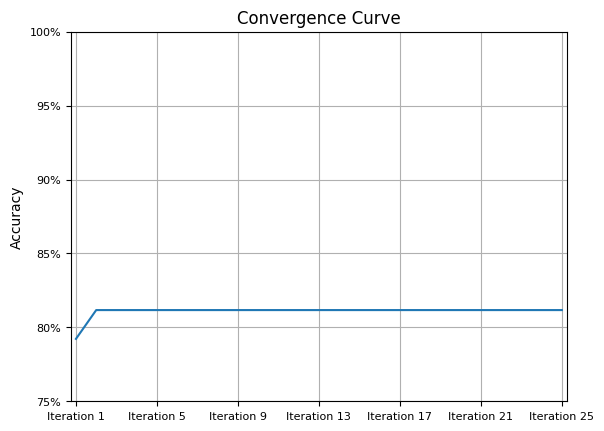

In [21]:
# Plot convergence curve
plt.plot(range(1, max_iterations + 1), accuracy_curve)
plt.title('Convergence Curve')
plt.ylabel('Accuracy')
plt.ylim(0.75, 1)
plt.xlim(0.75, 25.25)

# Set y-axis tick labels in percentage
yticks = plt.gca().get_yticks()
plt.gca().set_yticks(yticks)
plt.gca().set_yticklabels(['{:.0f}%'.format(y * 100) for y in yticks], fontsize=8)

# Set x-axis tick labels and ticks
xticks = range(1, max_iterations + 1, 4)
plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels(['Iteration {}'.format(x) for x in xticks], fontsize=8)
# Rotate xticks
plt.xticks(rotation=0)

plt.grid(True)
plt.show()

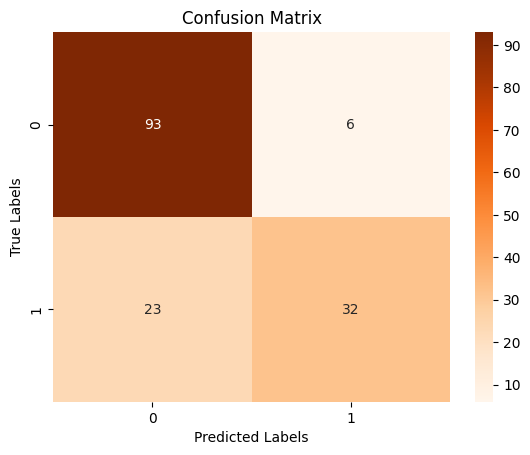

In [22]:
# Visualize Confusion Matrix
sns.heatmap(con_matrix, annot=True, cmap="Oranges")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [24]:
# Classification report
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.94      0.87        99
           1       0.84      0.58      0.69        55

    accuracy                           0.81       154
   macro avg       0.82      0.76      0.78       154
weighted avg       0.82      0.81      0.80       154

